# Groupe 3 - Projet Santé 

### Installations et importations

In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt

### Exploration du dataset

In [3]:
# XRay jusqu'à LIDC-IDRI-0291 inclus, puis scanner

In [4]:
dataset2 = pd.read_csv('/Users/mathildeoukaci/Desktop/EFREI/COURS/S9/PROJETSANTE/data/downloaded_data/manifest-1600709154662/metadata.csv',
                       header=0,
                       names=["Series UID", 
                              "Collection", 
                              "3rd Party Analysis",
                              "Data Description URI", 
                              "Subject ID", "Study UID", 
                              "Study Description", 
                              "Study Date", 
                              "Series Description",
                              "Manufacturer", 
                              "Modality", 
                              "SOP Class Name", 
                              "SOP Class UID", 
                              "Number of Images", 
                              "File Size", 
                              "File Location", 
                              "Download Timestamp",
                              "colA"])

In [5]:
dataset2.head()

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,colA
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.493562949900...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.116951808801...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,DX,Digital X-Ray Image Storage - For Presentation,1.2.840.10008.5.1.4.1.1.1.1,1,6,91 MB,./LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-26...,2022-10-28T12:50:05.161
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.141365756818...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.175012972118...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,DX,Digital X-Ray Image Storage - For Presentation,1.2.840.10008.5.1.4.1.1.1.1,2,16,36 MB,./LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-35...,2022-10-28T12:50:06.57
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0001,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,133,70,33 MB,./LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-NA-NA-30...,2022-10-28T12:50:12.422
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0002,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,261,137,73 MB,./LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-98...,2022-10-28T12:50:17.101
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,LIDC-IDRI,NaN,https://doi.org/10.7937/K9/TCIA.2015.LO9QL9SX,LIDC-IDRI-0003,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,NaN,01-01-2000,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,140,74,11 MB,./LIDC-IDRI/LIDC-IDRI-0003/01-01-2000-NA-NA-94...,2022-10-28T12:50:17.437


In [6]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Series UID            1308 non-null   object 
 1   Collection            1308 non-null   object 
 2   3rd Party Analysis    0 non-null      float64
 3   Data Description URI  1308 non-null   object 
 4   Subject ID            1308 non-null   object 
 5   Study UID             1308 non-null   object 
 6   Study Description     617 non-null    object 
 7   Study Date            1308 non-null   object 
 8   Series Description    464 non-null    object 
 9   Manufacturer          1308 non-null   object 
 10  Modality              1308 non-null   object 
 11  SOP Class Name        1308 non-null   object 
 12  SOP Class UID         1308 non-null   object 
 13  Number of Images      1308 non-null   int64  
 14  File Size             1308 non-null   int64  
 15  File Location        

In [7]:
dataset2.shape

(1308, 18)

### Visualisation des données pour un patient

In [8]:
test_patient = "./data/downloaded_data/manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0150/01-01-2000-NA-NA-42623/3189.000000-W Chest PA-93281/1-1.dcm"

In [9]:
ds = pydicom.dcmread(test_patient)

In [10]:
print(ds)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.526297199110497537882525691486
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', '', 'CSA RESAMPLED']
(0008, 0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008, 0018) SOP Instance UID              

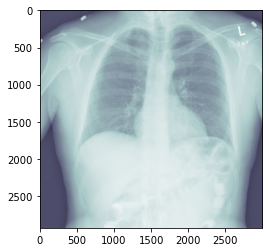

In [11]:
plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
plt.show()